### Waveforms

In [1]:
run_number = 6184

#### ZS data with sources, trigger at high energy

## Imports

In [2]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-07-05 21:43:33


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [5]:
from invisible_cities.reco.dst_functions  import load_dst

In [6]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

## NB functions

In [7]:
def plot_csum_csum_mau(csum, csum_mau,
                            t_min      =    0,
                            t_max      = 1200,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6)):
    """Plot signal versus time in mus (tmin, tmax in mus). """
    plt.figure(figsize=figsize)
    tstep = 25 # in ns
    PMTWL = csum.shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlim([t_min, t_max])
    ax1.set_ylim([signal_min, signal_max])
    mpl.set_plot_labels(xlabel = "t (mus)",
                    ylabel = "signal (pes/adc)")
    plt.plot(signal_t, csum, 'b')
    plt.plot(signal_t, csum_mau, 'r')

In [8]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times, s12.pmts.waveform(-1))

In [9]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [10]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


In [54]:
def plot_sipm_map(sipm_cal, t_min=0, t_max=1300, zoom=False):
    
    sipm_sums_w = np.sum(sipm_cal[:, t_min:t_max], axis=1)
    
    plt.figure()
    sipms_ = sipm_sums_w > 0 
    x = xs[sipms_]
    y = ys[sipms_]
    q = sipm_sums_w[sipms_]
    #print(np.argwhere(sipms_))
    plt.scatter(x, y, s=10, c=q, cmap="jet")
    
    if not zoom:
        plt.xlim(-200, 200)
        plt.ylim(-200, 200)
    plt.colorbar()

In [56]:
def plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min, t_max):

    sipm_sums = np.sum(sipm_cal, axis=0)
    
    t = np.arange(len(cwf_sum)) / 40
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, cwf_sum)
    plt.xlim(t_min , t_max )

    plt.subplot(2, 1, 2)
    plt.plot(sipm_sums)
    plt.xlim(t_min, t_max)

## Data base

In [12]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [13]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [14]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,24.8956,0.77,9.65758
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,26.1527,0.00,10.98320
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,28.0751,0.81,10.48550
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,28.0198,0.00,10.76870
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,32.5408,0.75,12.25110
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,24.9557,0.75,9.55162
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,27.9666,0.00,10.33970
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,35.8262,0.00,13.53750
8,8,2,PMT8,1,63.2737,-173.8430,0.000525,4.849600e-07,26.1784,0.00,9.52523
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,28.0920,0.00,9.82717


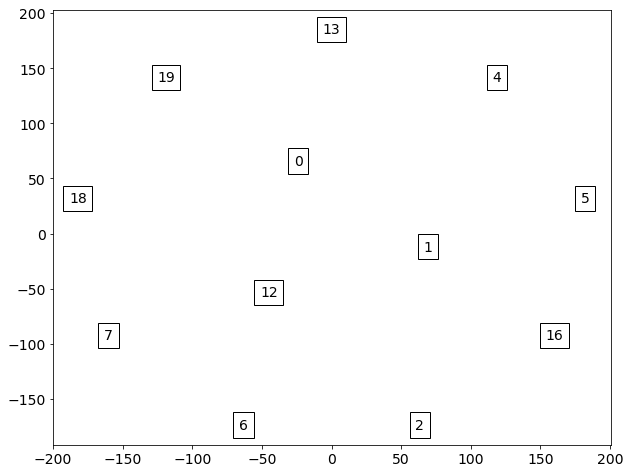

In [15]:
mpl.draw_pmt_map(run_number)

In [16]:
pmt_active

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [17]:
adc_to_pes

array([ 24.8956,  26.1527,  28.0751,  28.0198,  32.5408,  24.9557,
        27.9666,  35.8262,  26.1784,  28.092 ,  23.6226,  24.9109])

In [18]:
sipm_adc_to_pes = DataSiPM.adc_to_pes.values

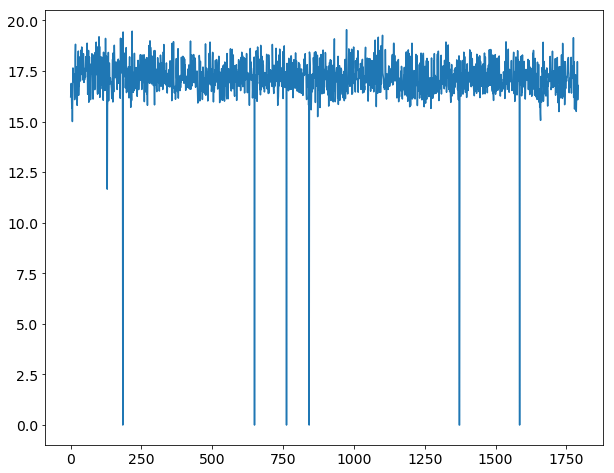

In [19]:
plt.plot(adc_to_pes_sipm)

## Input file

In [24]:
filename = f'$IC_DATA/wfm/{run_number}/run_{run_number}_2207_waveforms.h5'
h5rwf = tb.open_file(os.path.expandvars(filename), "r") 

In [25]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf

In [26]:
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape

In [27]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 241
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


In [28]:
evts = h5rwf.root.Run.events[:]

## S1 and S2 parameters

In [68]:
s1params = S12Params(time = minmax(min    = 100 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 5,
                           length = minmax(min = 5, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [71]:
s2params = S12Params(time = minmax(min    = 100 * units.mus,
                                   max    = 1300 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Event 0

In [31]:
event=0

In [32]:
evts[event]

(419331, 1530759434383)

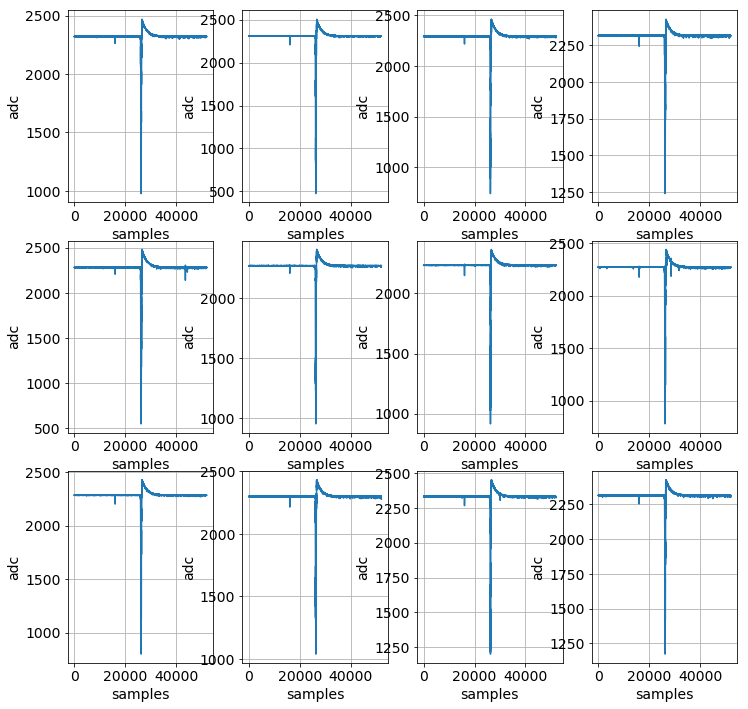

In [33]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

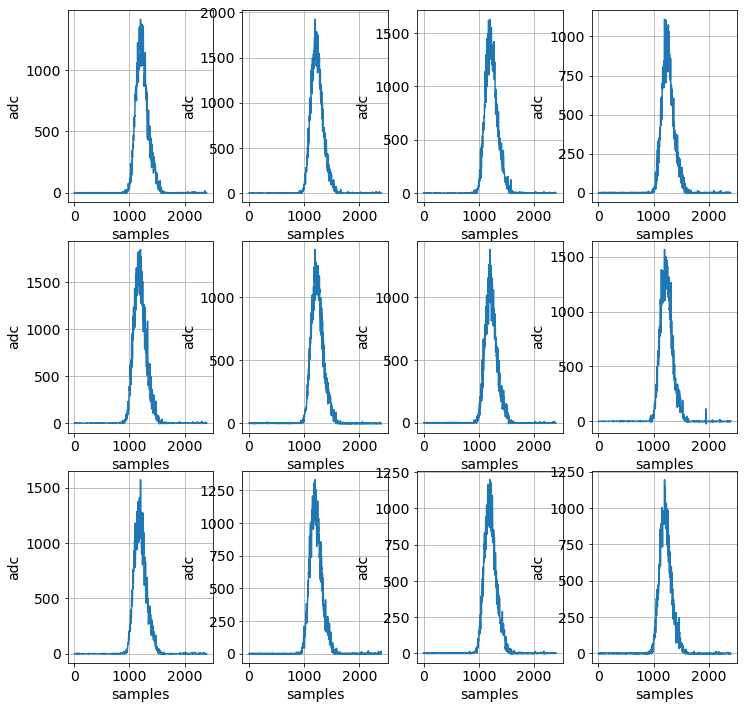

In [34]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

- Calibrated signal in all PMTs

In [35]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

- Calibrated sum

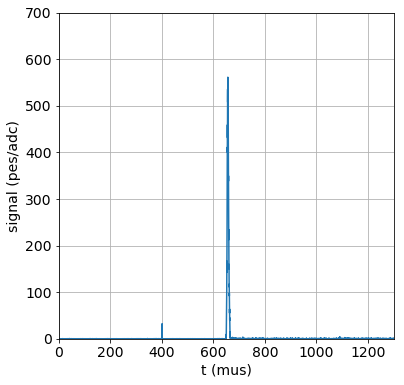

In [39]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  700,
                            figsize=(6,6))

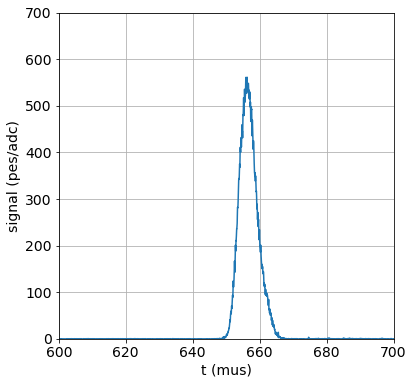

In [40]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  700,
                            figsize=(6,6))

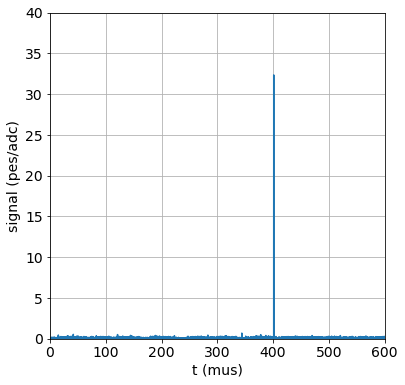

In [42]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  40,
                            figsize=(6,6))

#### Search for S1 and S2a

In [43]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)

In [44]:
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)

In [45]:
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 14
       Times: [ 400.975  401.     401.025  401.05   401.075  401.1    401.125  401.15
 401.175  401.2    401.225  401.25   401.275  401.3  ] µs
       Time @ max energy: 401.05
       Width: 0.325 µs
       Height: 32.360320693392836 pes
       Energy: 179.45822300942203 pes
       Charge: 0.0 pes
       RMS: 0.0641438454334211 µs]

In [46]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 2.0 * units.pes)

In [47]:
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)

In [48]:
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 19
       Times: [ 649.45298391  650.53393259  651.50854316  652.48025494  653.4593832
 654.42981914  655.42524142  656.41031144  657.3989087   658.38693773
 659.38048476  660.37636838  661.3740383   662.37375865  663.36303343
 664.3239491   665.32612078  666.24968141  666.95239188] µs
       Time @ max energy: 656.410311438694
       Width: 17.499407970779806 µs
       Height: 21494.20184813009 pes
       Energy: 141893.52028062782 pes
       Charge: 0.0 pes
       RMS: 2.689896924451348 µs]

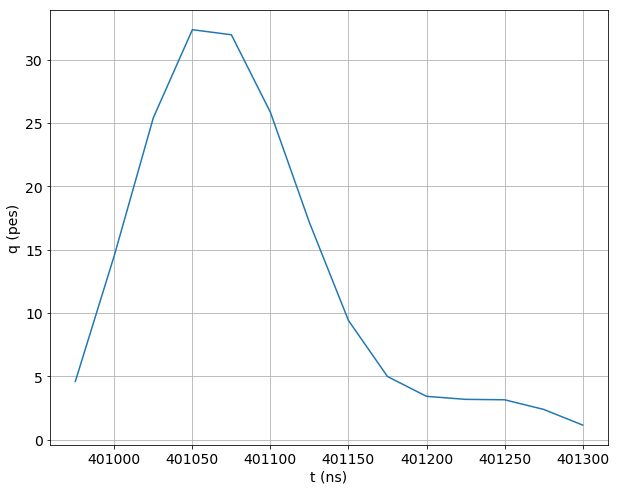

In [49]:
plot_S12(s1s)

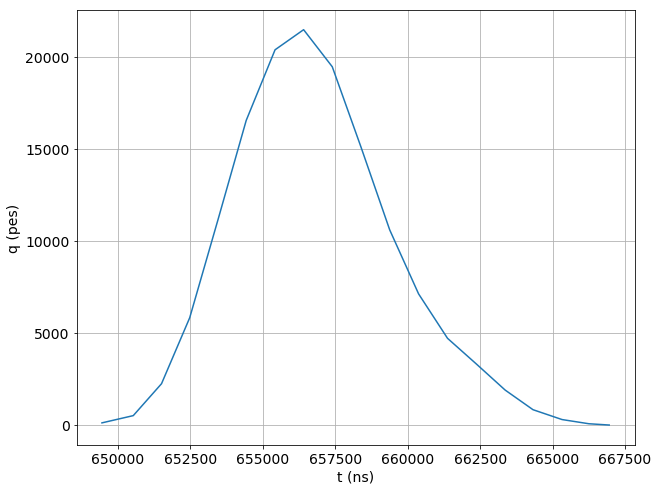

In [50]:
plot_S12(s2s)

In [51]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)

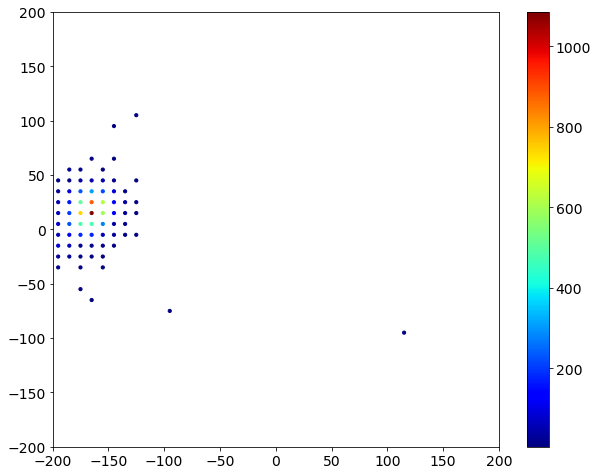

In [55]:
plot_sipm_map(sipm_cal)

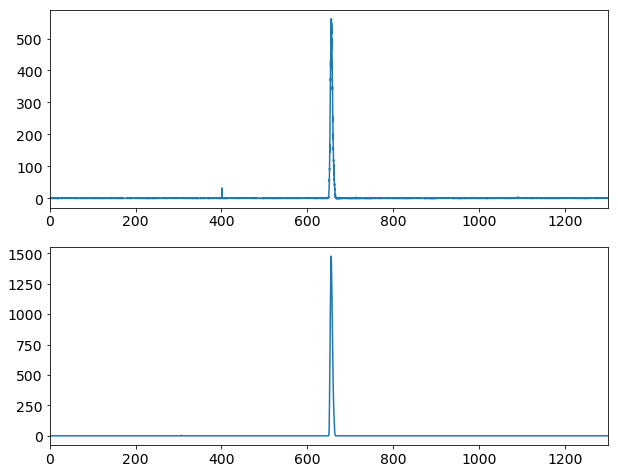

In [57]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

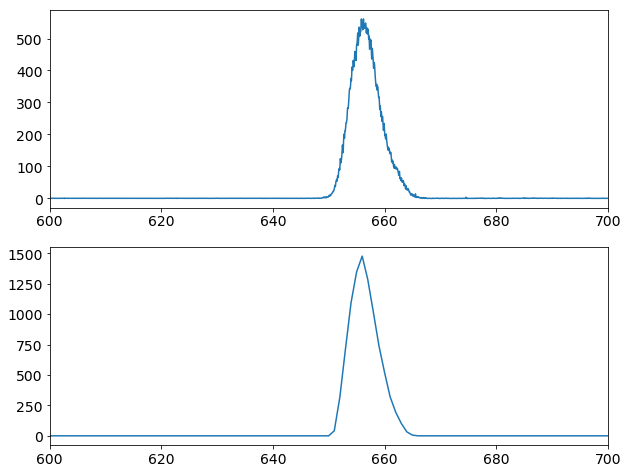

In [58]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

## Event 1

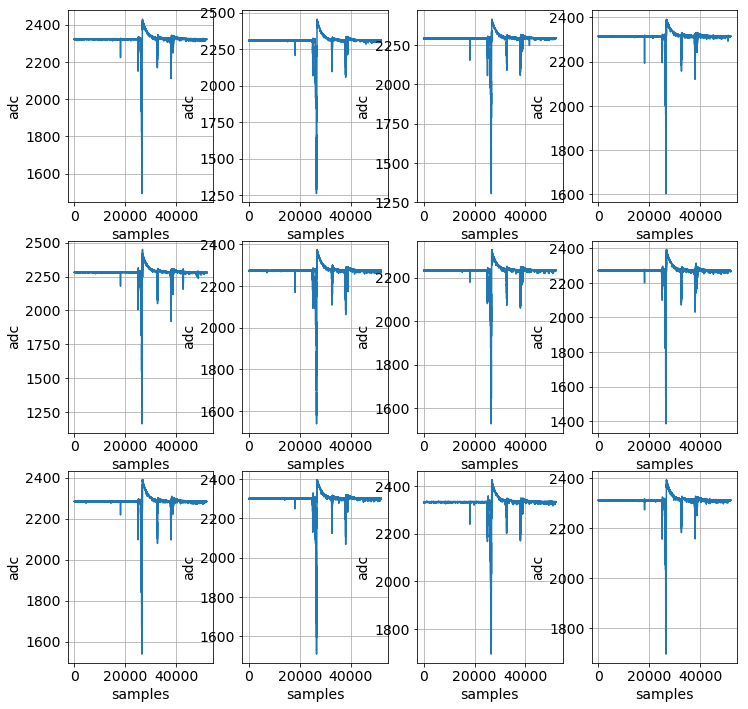

In [59]:
event=1
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

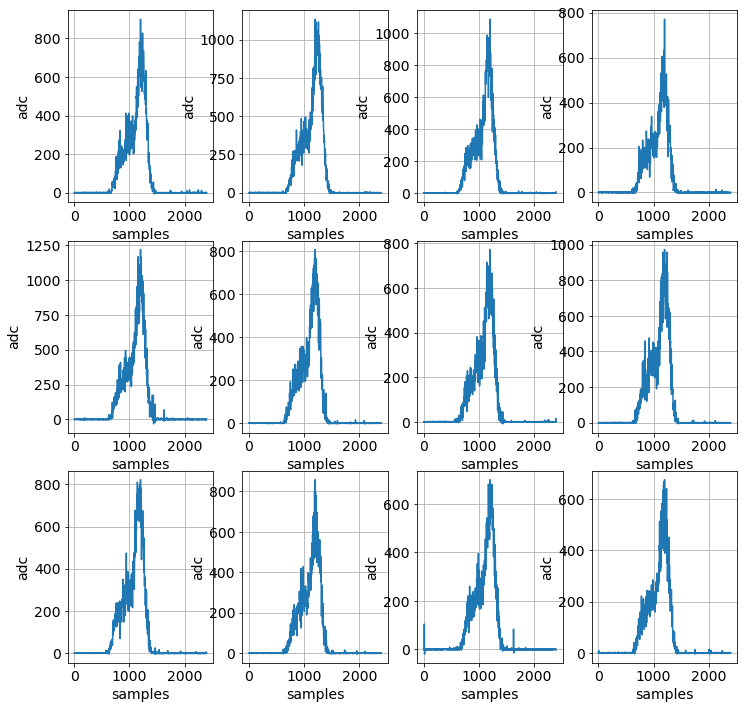

In [60]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [61]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

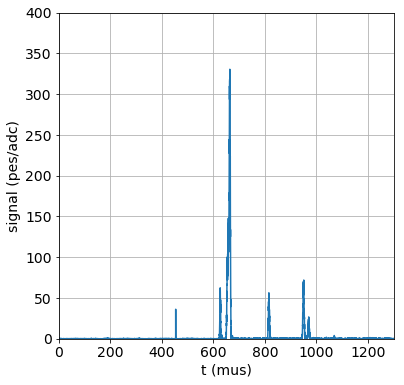

In [63]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

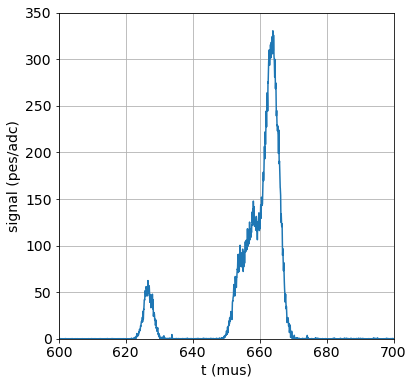

In [64]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  350,
                            figsize=(6,6))

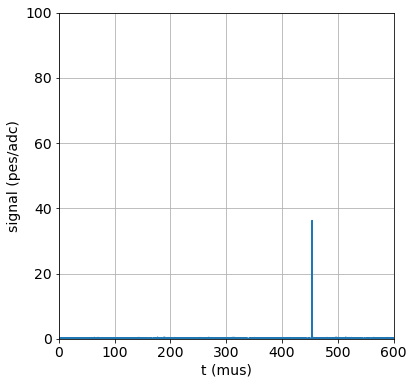

In [65]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [69]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 16
       Times: [ 453.725  453.75   453.775  453.8    453.825  453.85   453.875  453.9
 453.925  453.95   453.975  454.     454.025  454.05   454.075  454.1  ] µs
       Time @ max energy: 453.825
       Width: 0.375 µs
       Height: 36.24928526197984 pes
       Energy: 206.87163273891713 pes
       Charge: 0.0 pes
       RMS: 0.07321315350164082 µs]

In [72]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 9
       Times: [ 623.19521631  624.16328845  625.1130568   626.0486811   627.00191909
 628.00557575  628.95572474  629.8444234   631.06883923] µs
       Time @ max energy: 626.0486810988087
       Width: 7.873622917802888 µs
       Height: 1966.4850532586881 pes
       Energy: 7424.801911382388 pes
       Charge: 0.0 pes
       RMS: 1.3811571864491974 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 23
       Times: [ 649.33091885  650.27434525  651.22197884  652.21559423  653.1945068
 654.1730233   655.17113835  656.17593985  657.17049283  658.15997727
 659.15950582  660.17682612  661.19823637  662.18873909  663.16624947
 664.15142541  665.1369309   666.10822979  667.07665716  668.06624607
 669.04189934  670.02408708  670.89308462] µs
       Time @ max energy: 664.1514254132691
       Width: 21.56216577321512 µs
       Hei

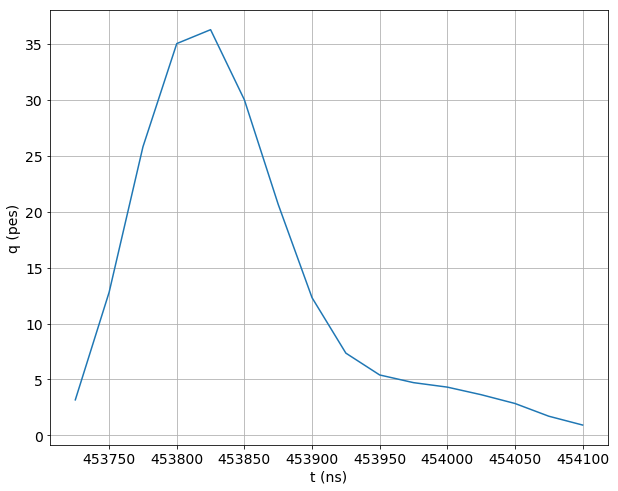

In [73]:
plot_S12(s1s)

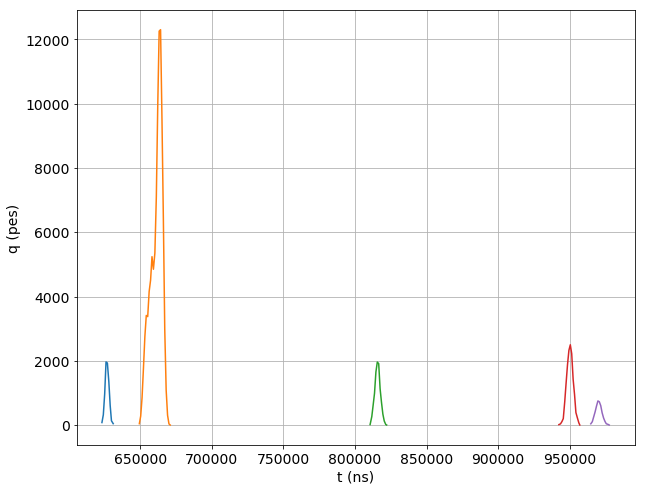

In [74]:
plot_S12(s2s)

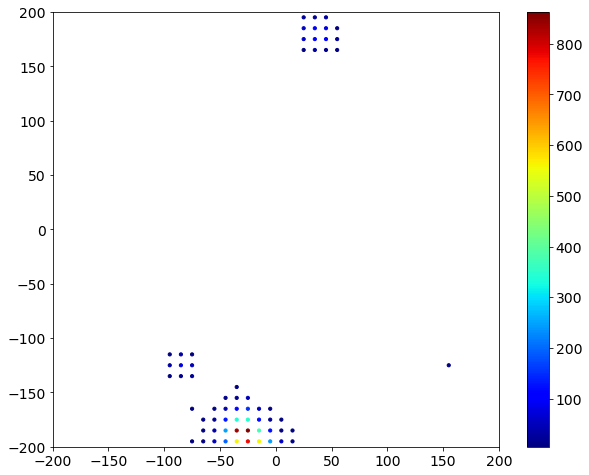

In [75]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

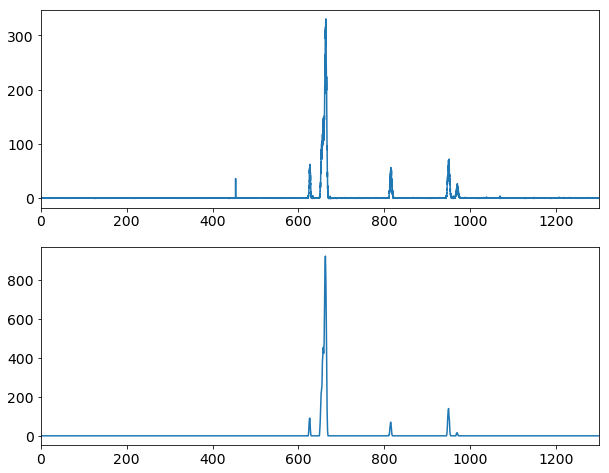

In [76]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 2

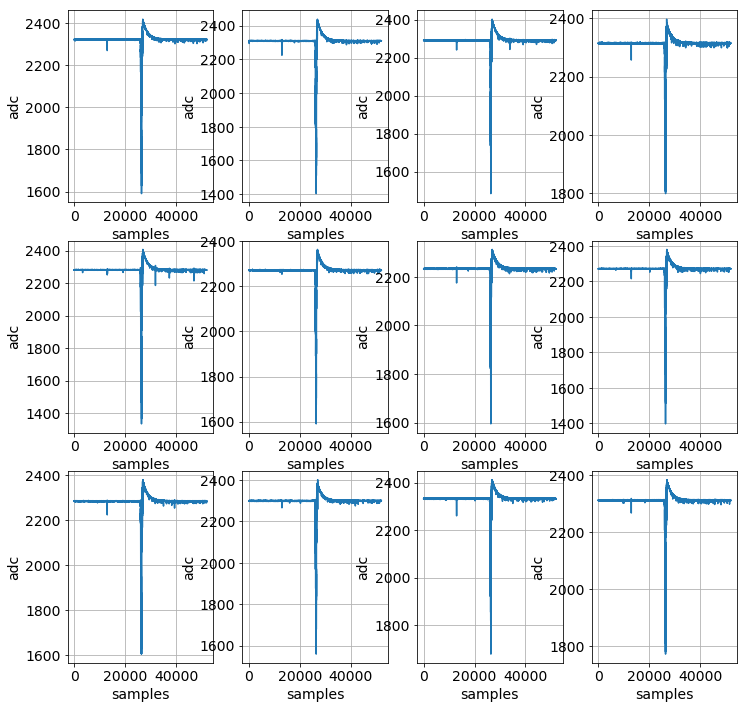

In [77]:
event=2
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

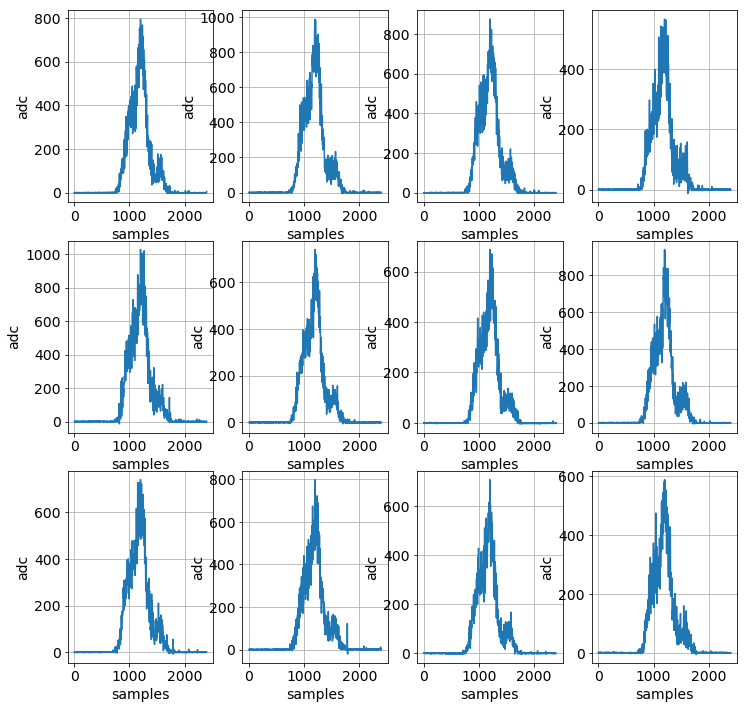

In [78]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [79]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

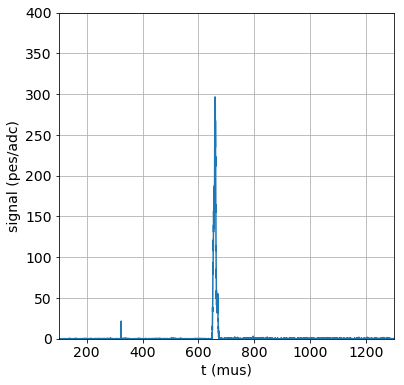

In [83]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

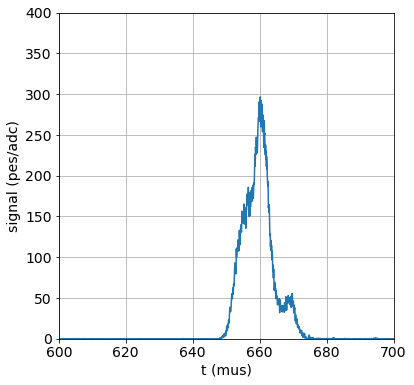

In [85]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

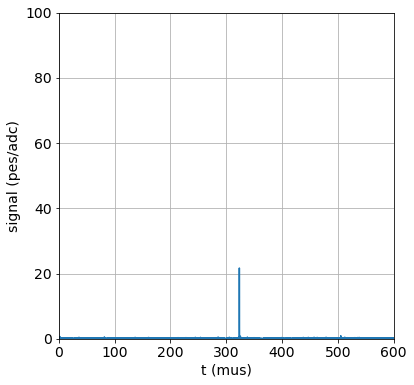

In [86]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [87]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 323.45   323.475  323.5    323.525  323.55   323.575  323.6    323.625
 323.65   323.675  323.7  ] µs
       Time @ max energy: 323.525
       Width: 0.25 µs
       Height: 21.701628346416683 pes
       Energy: 118.05281435241984 pes
       Charge: 0.0 pes
       RMS: 0.052038361155665014 µs]

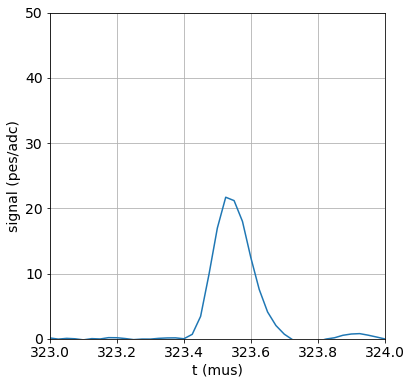

In [90]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =323,
                            t_max      = 324,
                            signal_min =    0,
                            signal_max =  50,
                            figsize=(6,6))

In [91]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 28
       Times: [ 648.77699654  649.7375881   650.73934076  651.68941127  652.67625487
 653.6472299   654.65089612  655.64099589  656.62932562  657.6426117
 658.66313878  659.65630498  660.63024055  661.62191453  662.59531123
 663.60098021  664.60172082  665.62464747  666.62766494  667.65123327
 668.63789868  669.63030034  670.58058776  671.5737612   672.56837547
 673.51793872  674.6864413   675.61550902] µs
       Time @ max energy: 660.6302405486978
       Width: 26.83851247436041 µs
       Height: 10935.783409604635 pes
       Energy: 100012.85293245588 pes
       Charge: 0.0 pes
       RMS: 4.446262249351107 µs]

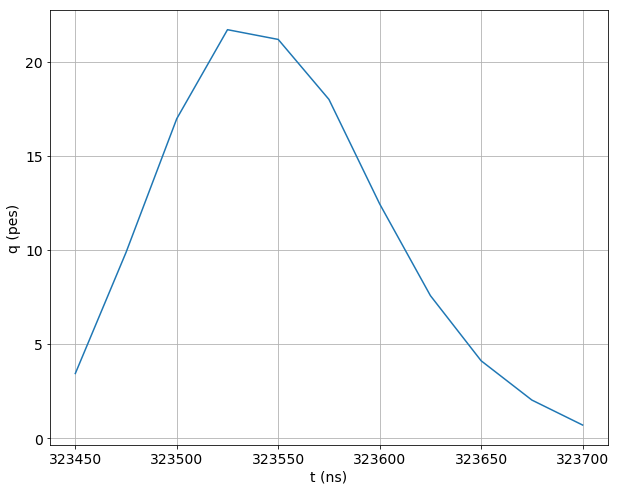

In [92]:
plot_S12(s1s)

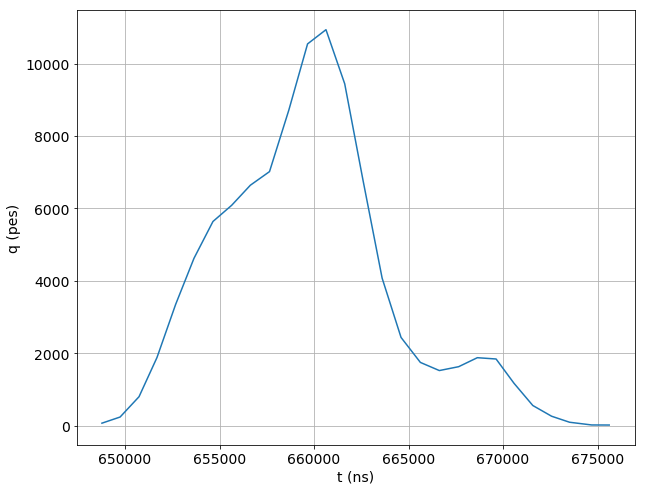

In [93]:
plot_S12(s2s)

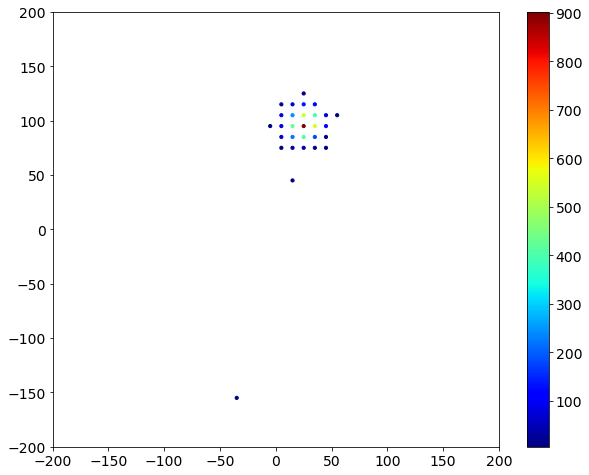

In [94]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

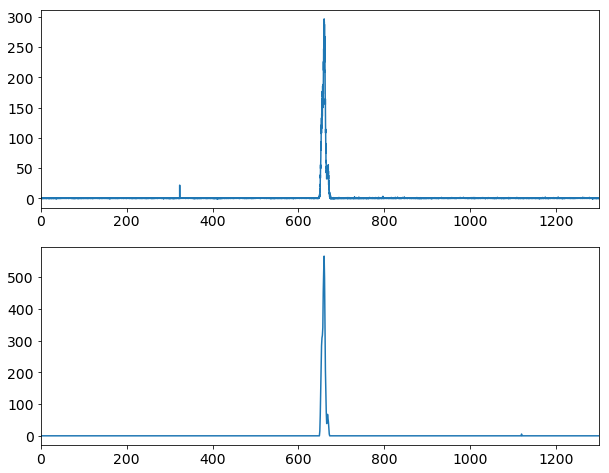

In [95]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 3

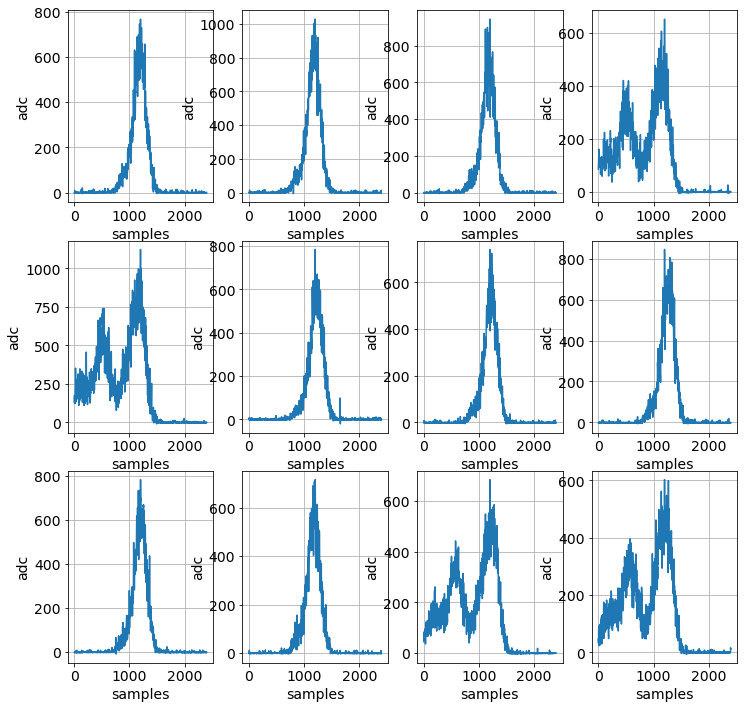

In [104]:
event=3
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

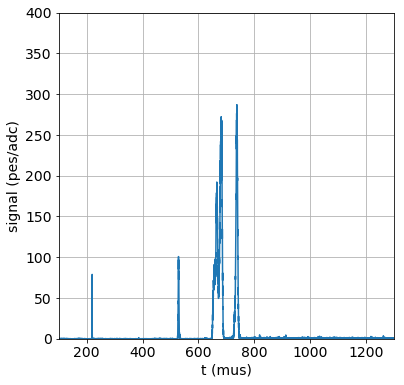

In [105]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

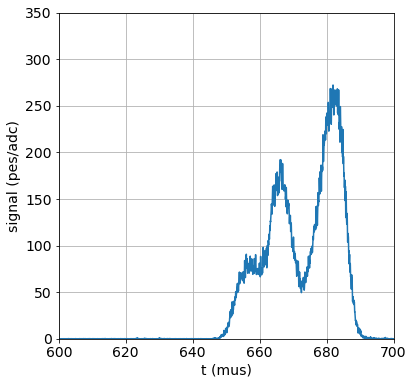

In [106]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  350,
                            figsize=(6,6))

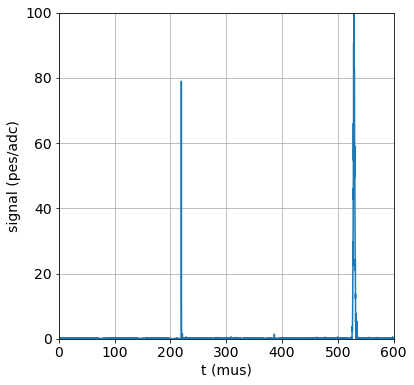

In [107]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [108]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 19
       Times: [ 219.475  219.5    219.525  219.55   219.575  219.6    219.625  219.65
 219.675  219.7    219.725  219.75   219.775  219.8    219.825  219.85
 219.875  219.9    219.925] µs
       Time @ max energy: 219.575
       Width: 0.45 µs
       Height: 78.95607103415458 pes
       Energy: 445.828366288191 pes
       Charge: 0.0 pes
       RMS: 0.07657672339148804 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 386.15   386.175  386.2    386.225  386.25   386.275  386.3    386.325] µs
 Time @ max energy: 386.225
 Width: 0.175 µs
 Height: 1.415486286612741 pes
 Energy: 7.188412944215782 pes
 Charge: 0.0 pes
 RMS: 0.046155905421340924 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 534.3    534.325  534.35   534.375  534.4    534.425] µs
 Time @ max energy: 534.35
 Width: 0.125 µs
 

In [109]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 526.13620256  527.10637648  528.07799131  529.00669068  529.96088652
 530.94615721  531.85669075  532.6941663 ] µs
       Time @ max energy: 529.0066906794126
       Width: 6.557963745325222 µs
       Height: 3417.1175521627083 pes
       Energy: 11071.358076127068 pes
       Charge: 0.0 pes
       RMS: 1.2086476353708675 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 46
       Times: [ 648.51037476  649.47333107  650.4587611   651.43377302  652.43134632
 653.41092909  654.38929953  655.40412759  656.37553053  657.38605737
 658.40271836  659.39029459  660.37993844  661.3906968   662.41052182
 663.41527898  664.39511779  665.38510903  666.3827326   667.37639614
 668.37881486  669.36268199  670.36885292  671.36861392  672.37698908
 673.39648377  674.40756315  675.40158098  676.40356409  677.41131977
 678.40

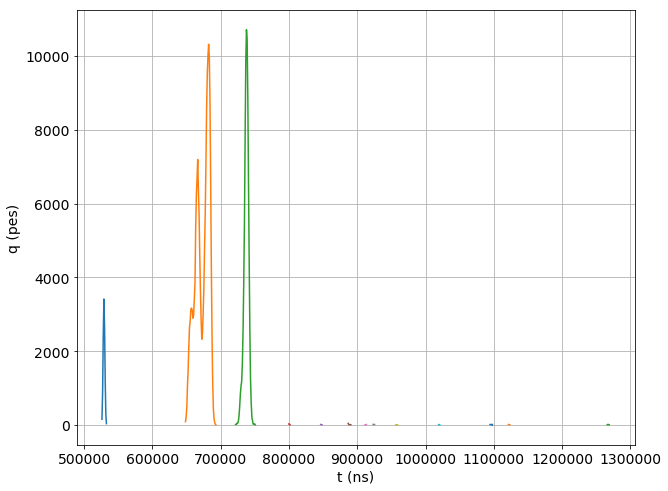

In [110]:
plot_S12(s2s)

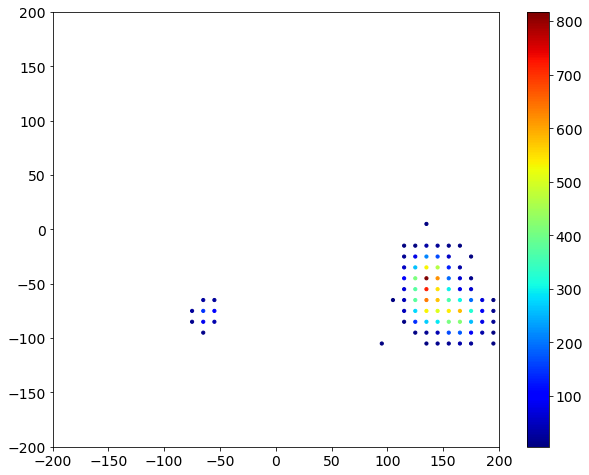

In [111]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

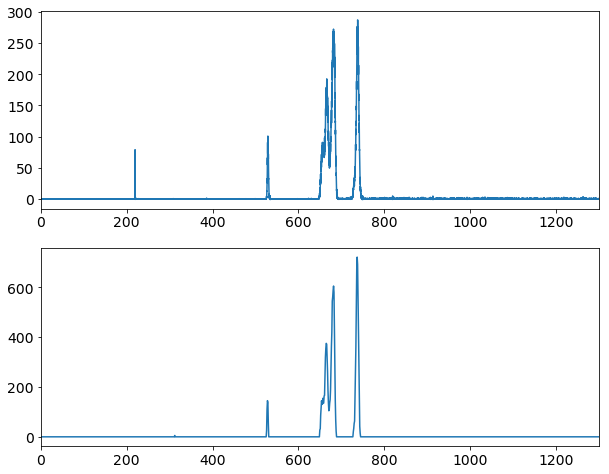

In [112]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 4

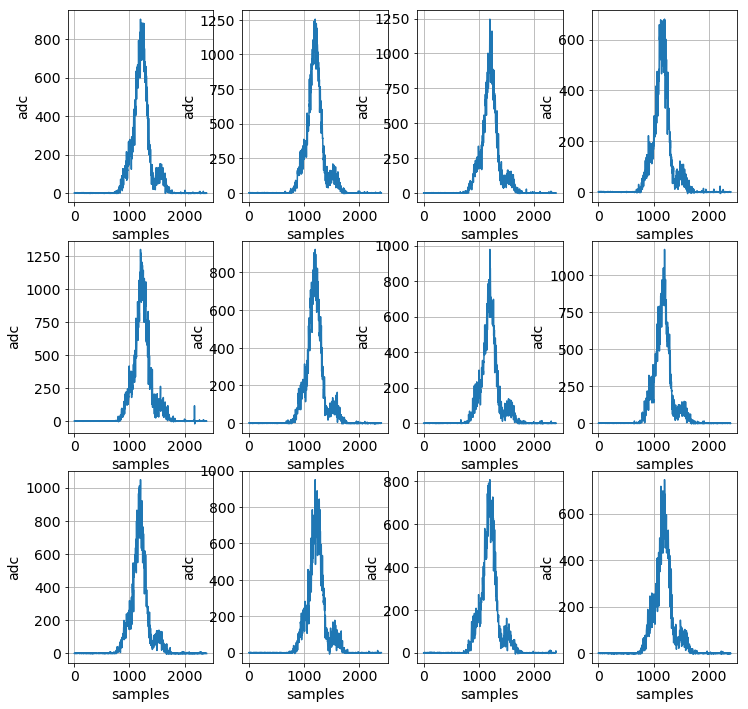

In [113]:
event=4
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

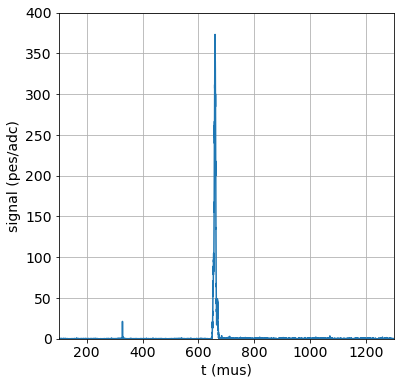

In [114]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

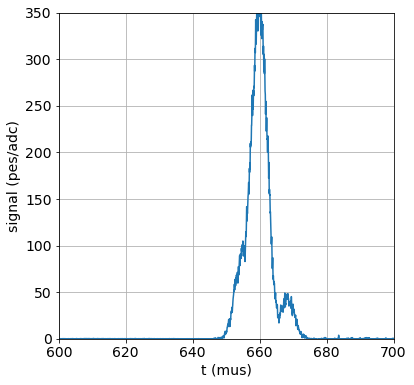

In [115]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  350,
                            figsize=(6,6))

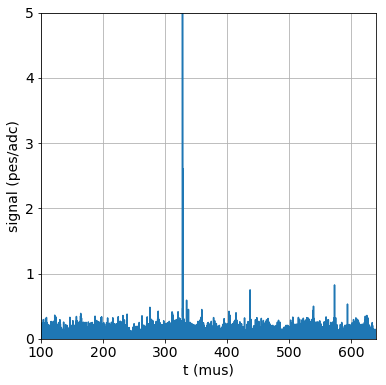

In [116]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 640,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [117]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 15
       Times: [ 328.025  328.05   328.075  328.1    328.125  328.15   328.175  328.2
 328.225  328.25   328.275  328.3    328.325  328.35   328.375] µs
       Time @ max energy: 328.1
       Width: 0.35 µs
       Height: 21.310934865606814 pes
       Energy: 109.88585877032338 pes
       Charge: 0.0 pes
       RMS: 0.06275621426681097 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 328.925  328.95   328.975  329.     329.025] µs
 Time @ max energy: 328.975
 Width: 0.1 µs
 Height: 2.604765596110004 pes
 Energy: 9.331448144320355 pes
 Charge: 0.0 pes
 RMS: 0.030053110626839536 µs]

In [118]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 27
       Times: [ 648.02831708  649.1565632   650.13287193  651.08259546  652.10309957
 653.04763376  654.06209597  655.03475073  656.08455238  657.06963902
 658.05522274  659.04903492  660.03125896  661.0228369   662.01280318
 662.98010745  663.97533655  664.98111795  666.07878099  667.06799976
 668.05671464  669.03288926  670.03093951  670.97737149  671.96424597
 673.01538315  673.78758982] µs
       Time @ max energy: 660.0312589612188
       Width: 25.75927273555135 µs
       Height: 14313.47332879898 pes
       Energy: 103092.98263662956 pes
       Charge: 0.0 pes
       RMS: 3.8665542620830715 µs]

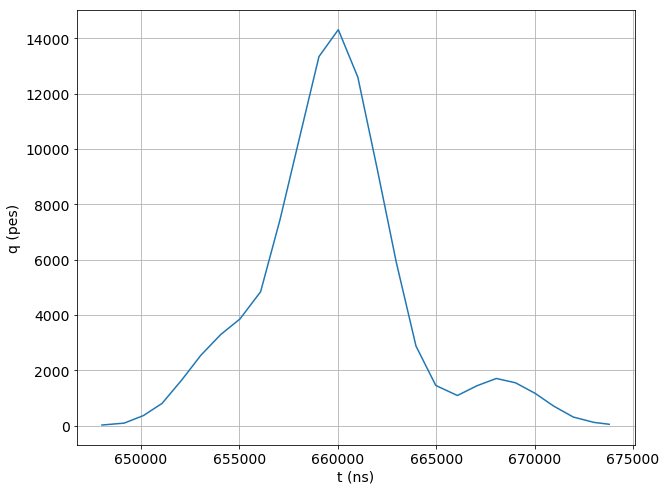

In [119]:
plot_S12(s2s)

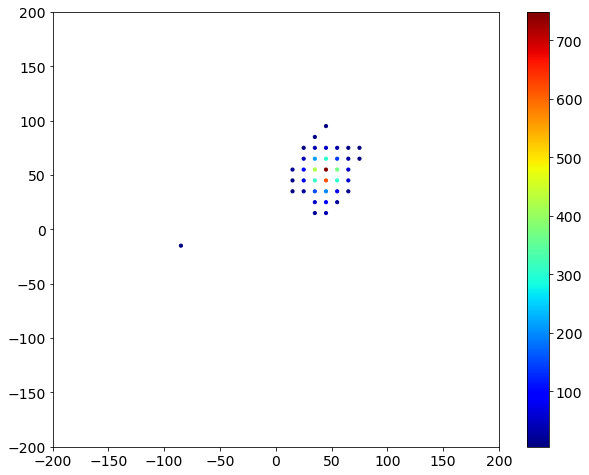

In [120]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

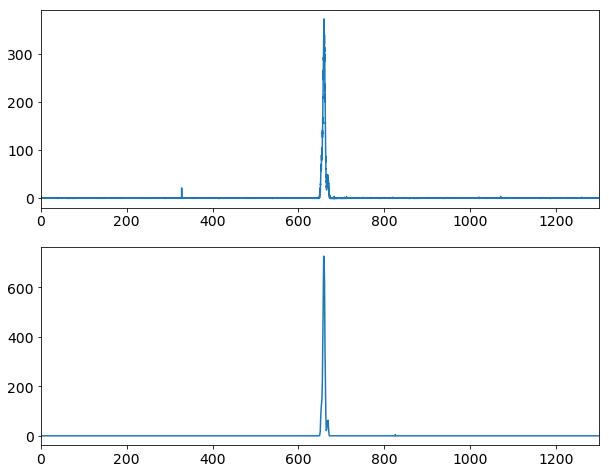

In [121]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 5

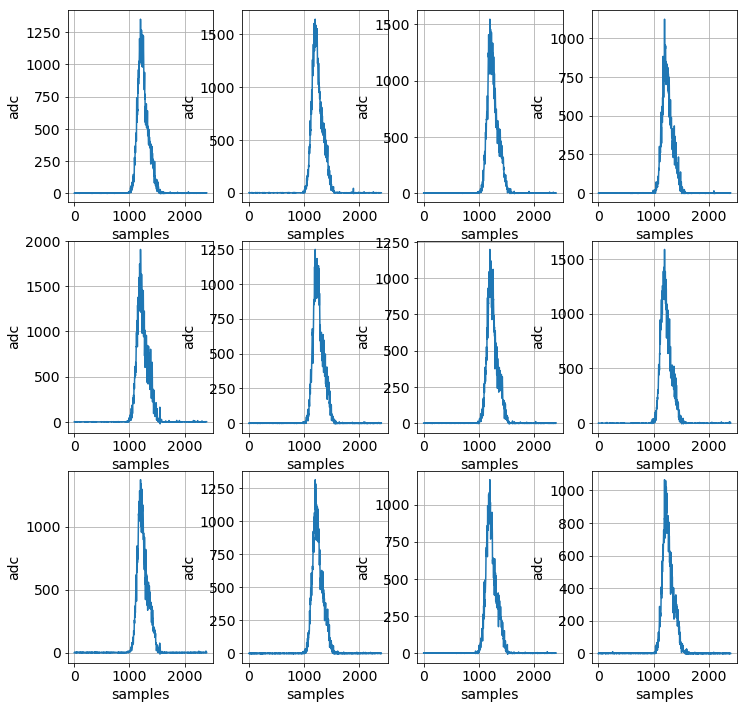

In [122]:
event=5
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

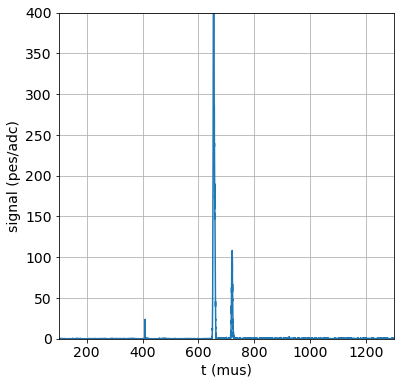

In [123]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

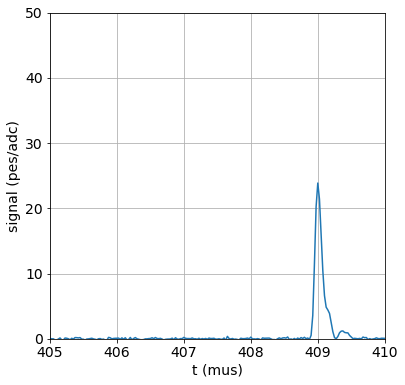

In [131]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =405,
                            t_max      = 410,
                            signal_min =    0,
                            signal_max =  50,
                            figsize=(6,6))

In [124]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[]

In [125]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 16
       Times: [ 649.80437173  650.77050738  651.77406586  652.72806204  653.706834
 654.66653455  655.64896212  656.62068421  657.63217001  658.64769053
 659.63200965  660.59442682  661.58375073  662.55503583  663.56382741
 664.23580684] µs
       Time @ max energy: 654.6665345492912
       Width: 14.431435107975151 µs
       Height: 19976.550774845622 pes
       Energy: 106059.2701630735 pes
       Charge: 0.0 pes
       RMS: 2.344146518725136 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 715.95037239  716.87039246  717.89142997  718.86178185  719.8376098
 720.82862259  721.7940014   722.77622609  723.72088297  724.75602813
 725.74910736  726.63842129  728.0130593 ] µs
       Time @ max energy: 721.7940014001563
       Width: 12.062686912675389 µs
       Height: 3627.86817731863 pes
       Energy: 1

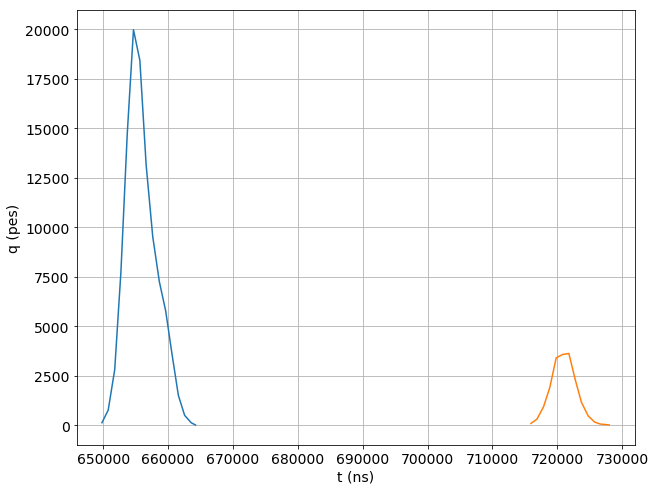

In [126]:
plot_S12(s2s)

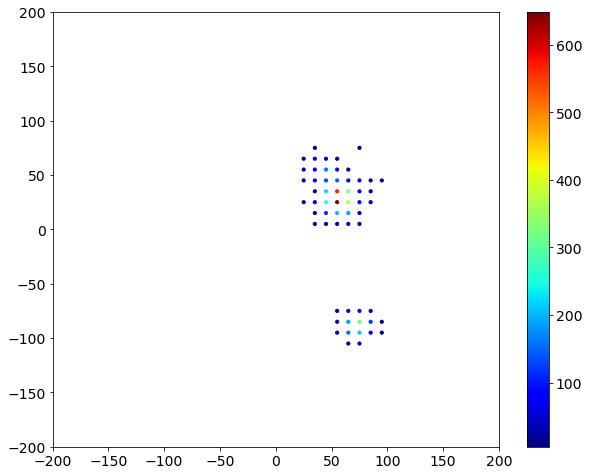

In [127]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

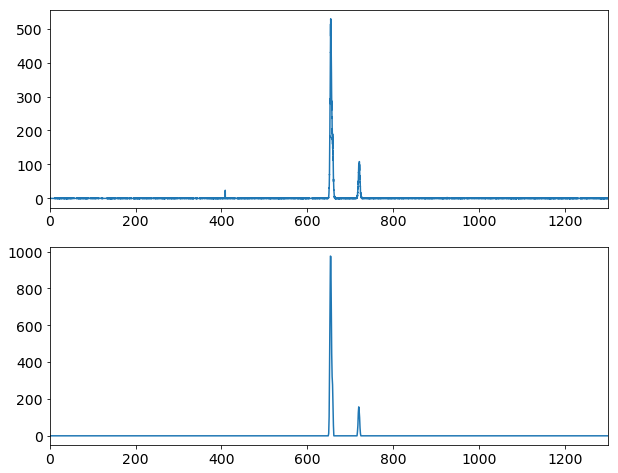

In [128]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 7

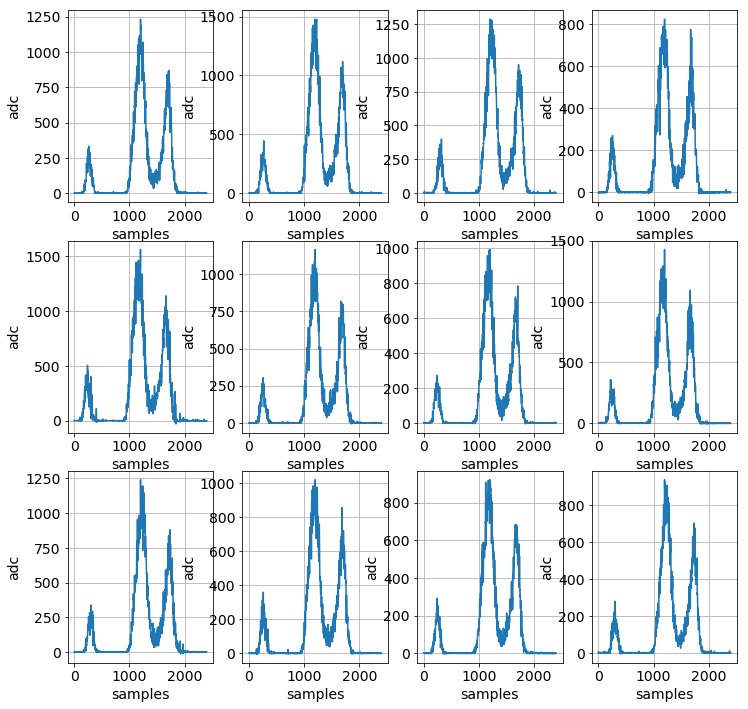

In [132]:
event=50
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

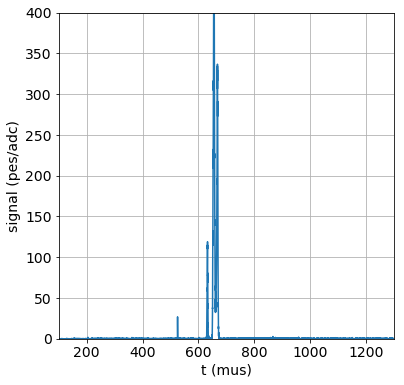

In [133]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

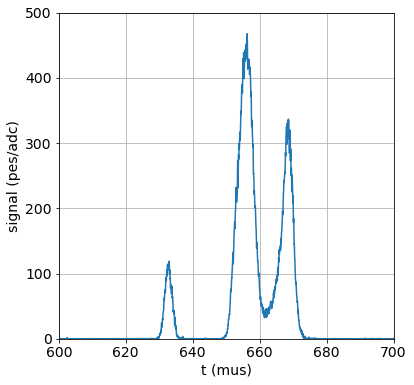

In [134]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      =700,
                            signal_min = 0,
                            signal_max =  500,
                            figsize=(6,6))

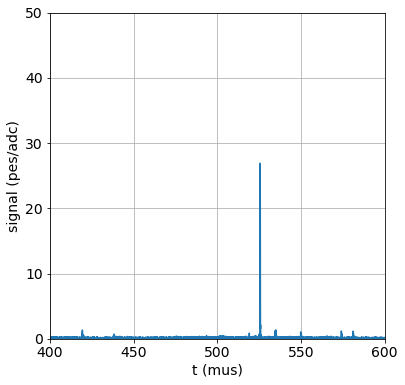

In [135]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =400,
                            t_max      =600,
                            signal_min = 0,
                            signal_max =  50,
                            figsize=(6,6))

In [136]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 13
       Times: [ 153.925  153.95   153.975  154.     154.025  154.05   154.075  154.1
 154.125  154.15   154.175  154.2    154.225] µs
       Time @ max energy: 153.95
       Width: 0.3 µs
       Height: 0.9983948298095949 pes
       Energy: 9.02496548536849 pes
       Charge: 0.0 pes
       RMS: 0.0940691279906691 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 219.425  219.45   219.475  219.5    219.525  219.55   219.575  219.6
 219.625  219.65   219.675  219.7  ] µs
       Time @ max energy: 219.45
       Width: 0.275 µs
       Height: 1.235491742202933 pes
       Energy: 7.947549394223019 pes
       Charge: 0.0 pes
       RMS: 0.09610524987037972 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 242.2    242.225  242.25   242.275  242.3  ] µs
 Time @ max

In [137]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 630.10090745  631.06561592  631.98763897  632.91235763  633.86935038
 634.76761252  635.80676692  636.83571197] µs
       Time @ max energy: 632.9123576265008
       Width: 6.734804521581042 µs
       Height: 4179.677083214401 pes
       Energy: 12125.933326560349 pes
       Charge: 0.0 pes
       RMS: 1.0585525639863869 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 27
       Times: [ 649.4517206   650.45588081  651.38667439  652.33781374  653.31185787
 654.31504419  655.29588248  656.28276372  657.26095391  658.24211057
 659.23025321  660.23352806  661.27442612  662.29869236  663.30196681
 664.32307178  665.32071402  666.31669243  667.32087687  668.29321506
 669.26194175  670.20150195  671.18664063  672.19566271  673.11748001
 674.3991057   674.84147399] µs
       Time @ max energy: 656.2827637205712
  

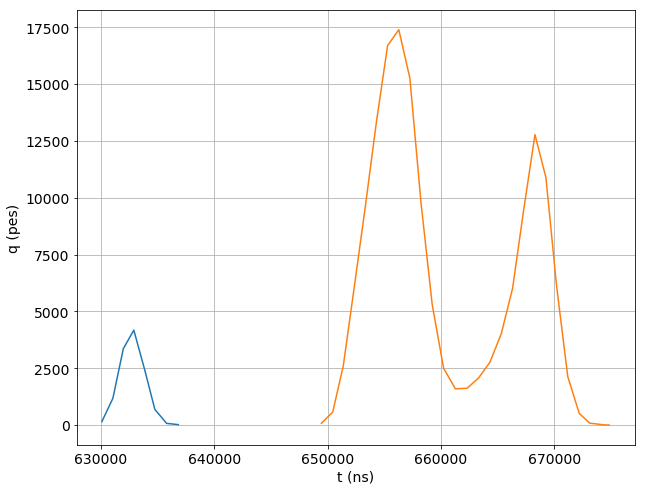

In [138]:
plot_S12(s2s)

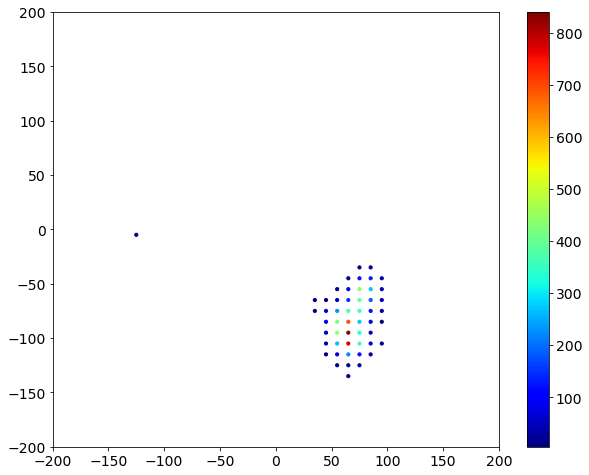

In [139]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

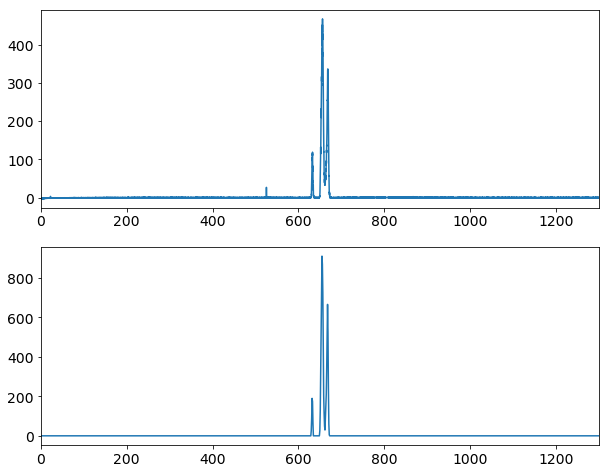

In [140]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 8

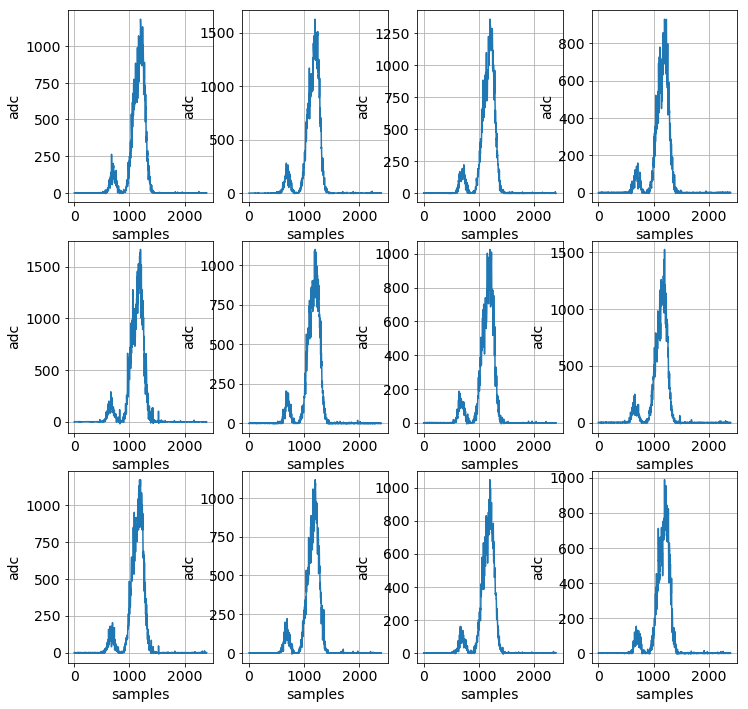

In [141]:
event=100
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [493]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 144.7    144.725  144.75   144.775  144.8    144.825] µs
 Time @ max energy: 144.775
 Width: 0.125 µs
 Height: 1.062000844458278 pes
 Energy: 5.440977204520116 pes
 Charge: 0.0 pes
 RMS: 0.041221484883326304 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 16
       Times: [ 579.4    579.425  579.45   579.475  579.5    579.525  579.55   579.575
 579.6    579.625  579.65   579.675  579.7    579.725  579.75   579.775] µs
       Time @ max energy: 579.65
       Width: 0.375 µs
       Height: 2.2371515247193203 pes
       Energy: 16.36400976328754 pes
       Charge: 0.0 pes
       RMS: 0.10183018662022232 µs]

In [494]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 16
       Times: [ 647.17568513  648.07258785  649.03131553  650.05158861  651.06255409
 652.02621422  653.05004852  653.99054185  654.96675804  655.98569685
 656.96651304  657.98511707  658.92688336  659.84469839  661.03799774
 662.03474701] µs
       Time @ max energy: 653.9905418495591
       Width: 14.85906187888817 µs
       Height: 1666.0567445878462 pes
       Energy: 9658.419778418916 pes
       Charge: 0.0 pes
       RMS: 2.4944459607356424 µs]

[[   7]
 [ 339]
 [ 340]
 [ 341]
 [ 348]
 [ 349]
 [ 350]
 [ 356]
 [ 357]
 [1373]
 [1620]]


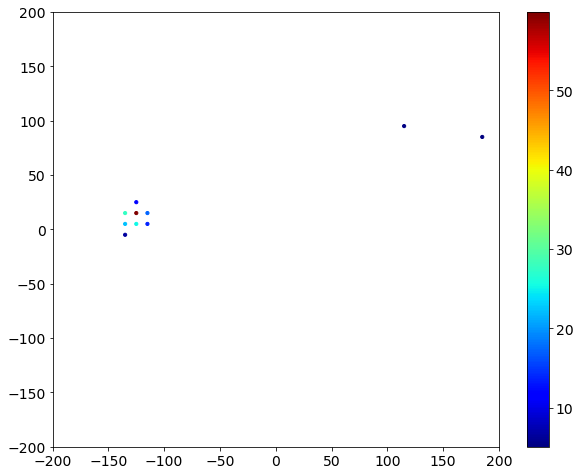

In [495]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 9

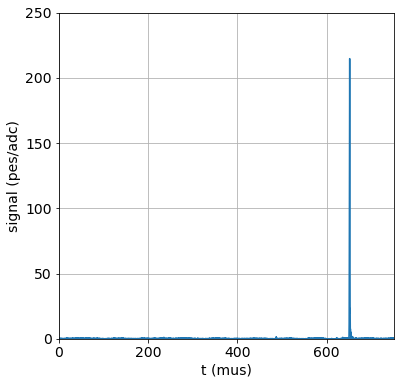

In [496]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [497]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 235.3    235.325  235.35   235.375  235.4  ] µs
 Time @ max energy: 235.35
 Width: 0.1 µs
 Height: 1.2401200158401933 pes
 Energy: 4.672192514828558 pes
 Charge: 0.0 pes
 RMS: 0.032199099873594664 µs]

In [498]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 5
 Times: [ 650.72717418  651.49255066  652.27634597  653.29010286  654.37669129] µs
 Time @ max energy: 651.4925506622515
 Width: 3.6495171114220284 µs
 Height: 7132.084325510339 pes
 Energy: 10757.990494750455 pes
 Charge: 0.0 pes
 RMS: 0.5167236518622047 µs]

[[   7]
 [  62]
 [ 200]
 [ 261]
 [ 262]
 [ 263]
 [ 268]
 [ 269]
 [ 270]
 [ 271]
 [ 277]
 [ 278]
 [ 279]
 [ 287]
 [1550]]


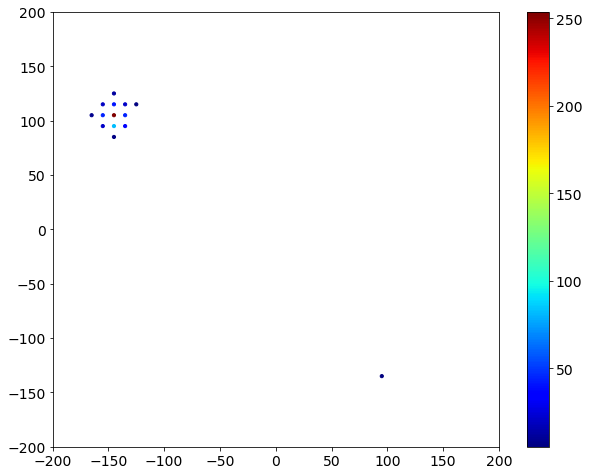

In [499]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 10

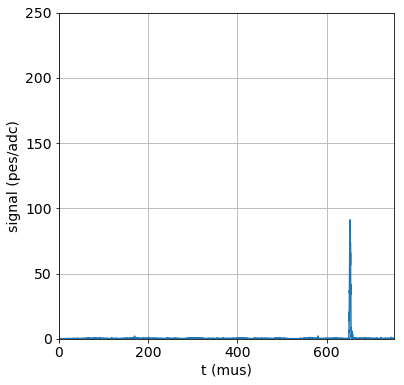

In [500]:
event=10
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [501]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 169.55   169.575  169.6    169.625  169.65   169.675  169.7    169.725] µs
 Time @ max energy: 169.6
 Width: 0.175 µs
 Height: 1.843711530363468 pes
 Energy: 11.254096337011662 pes
 Charge: 0.0 pes
 RMS: 0.05204191006892893 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 581.     581.025  581.05   581.075  581.1    581.125  581.15   581.175
 581.2    581.225  581.25 ] µs
       Time @ max energy: 581.05
       Width: 0.25 µs
       Height: 2.112755124272919 pes
       Energy: 10.59457502482847 pes
       Charge: 0.0 pes
       RMS: 0.07339820191857883 µs]

In [502]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 650.2054866   651.11360246  652.04479943  652.97438481  653.90722071
 654.86082292  656.06360115  656.72907918] µs
       Time @ max energy: 652.0447994312294
       Width: 6.523592580889235 µs
       Height: 3059.259707659702 pes
       Energy: 9099.926683479587 pes
       Charge: 0.0 pes
       RMS: 1.0477653155234283 µs]

[[   7]
 [ 208]
 [1624]
 [1677]
 [1678]
 [1685]
 [1686]
 [1687]
 [1692]
 [1693]
 [1694]
 [1695]
 [1701]
 [1702]
 [1703]
 [1709]]


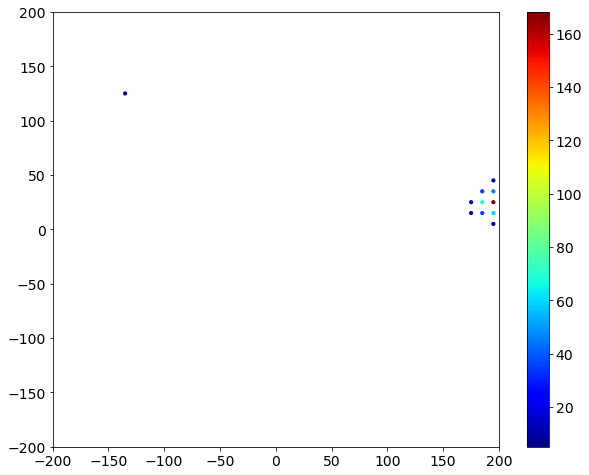

In [503]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)